In [ ]:
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn nltk
!pip install swifter
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=6b4cde19f10634e001322b7093ec5c22bfe2a4c907a775b2a955d660fd077f66
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings


In [ ]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re
import swifter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from imblearn.over_sampling import SMOTE
from IPython import get_ipython
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = '/content/drive/MyDrive/Dataset/Rev1_output_labelling.csv'
news = pd.read_csv(data, encoding= 'unicode_escape')
news

,tokoh,title,date,description,Rev1_label
0,anies baswedan,Anies Bertemu Relawan Pendukungnya di Australi...,"Senin, 06 Mar 2023 10:15 WIB",\-\n\nMantan Gubernur DKI Jakarta Anies Baswed...,1
1,anies baswedan,"PKS Bahagia Prabowo Bertemu Paloh: Bravo, Kian...","Senin, 06 Mar 2023 08:57 WIB",\-\n\nKetum Gerindra Prabowo Subianto bertemu ...,1
2,anies baswedan,Bos PPI Nilai Prabowo dan Paloh Sudah Siap Pis...,"Senin, 06 Mar 2023 09:00 WIB","\-\n\nDalam pertemuannya di Hambalang, Bogor, ...",1
3,anies baswedan,Riuh IMB Era Anies Diungkit PDIP Usai Kebakara...,"Senin, 06 Mar 2023 08:00 WIB",\-\n\nRiuh soal izin mendirikan bangunan (IMB)...,-1
4,anies baswedan,"Prabowo soal Anies: Siap Hadapi, Rakyat yang M...","Senin, 06 Mar 2023 08:55 WIB",\-\n\nBakal calon presiden dari Partai Gerindr...,0
...,...,...,...,...,...
877,prabowo,Prabowo 'Lawan' Anies Baswedan di Pilpres 2024...,"Senin, 06 Mar 2023 14:13 WIB",\-\n\nBakal calon presiden (Capres) Partai Ger...,1
878,prabowo,Terkini! Peta Kekuatan Prabowo dan Anies Jelan...,"Senin, 06 Mar 2023 13:47 WIB",\-\n\nDua bakal calon presiden Prabowo Subiant...,0
879,prabowo,NasDem Punya Tafsir Tersendiri soal Prabowo Si...,"Senin, 06 Mar 2023 16:18 WIB",\-\n\nCalon presiden Partai Gerindra Prabowo S...,0
880,prabowo,Duet Anies-Sandi Dinilai Kecil Kemungkinan Ter...,"Selasa, 07 Mar 2023 06:41 WIB",\-\n\nWacana duet Anies Baswedan dan Sandiaga ...,0


In [ ]:
news = pd.read_csv(data, encoding= 'unicode_escape')

In [ ]:
print(news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tokoh        882 non-null    object
 1   title        882 non-null    object
 2   date         882 non-null    object
 3   description  882 non-null    object
 4   Rev1_label   882 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 34.6+ KB
None


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def preprocess(text):
    text = text.lower()  # Case folding
    text = re.sub(r'[-+]?[0-9]+', ' ', text)           # number
    text = re.sub(r"_", " ", text)
    text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\'," ")    # remove tab, new line, and back slice
    text = re.sub(r'((http|https)\:\/\/)[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', " ", text)
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())            # remove mention, link, hashtag
    text = re.sub(r'[^\w\s]',' ', text)                # punctuation
    text = re.sub('\s+',' ',text)                     # multiple whitespace into single whitespace
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    return text

In [ ]:
def rev_space(text):
  text = re.sub('\s+',' ',text)
  return text

In [ ]:
def word_tokenizing(text):
    return word_tokenize(text)

In [ ]:
def remove_stopwords(kata):
  stopwords_ind = stopwords.words('indonesian')
  stopwords_ind.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 'nggak', 'gambas', 'video', 'ala',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah', "detik", "detikjatim", "detikjateng",
                        "detikjabar", "detiksulsel", "detiksumbar", "detikbali",
                        "detikpapua", "detiksulteng", "detikmaluku", "detjatim",
                        "detikcom", "allahumma", "aamiin", "allah", "bismillah",
                        "20detik", "gambasvideo", 'simak', 'lengkap', 'sini', 'halaman','halaman selanjutnya'])
  stopwords_ind = set(stopwords_ind)
  return [word
            for word in kata
              if word not in stopwords_ind]

In [ ]:
def stemmed_wrapper(words):
  words = stemmer.stem(words)
  return words

In [ ]:
def stemmingText(document):
    return [term_dict.get(term, term) for term in document]

# Preprocessing Results

In [ ]:
news = news.copy()

In [ ]:
news['text'] = news['title'] + ' ' + news['description']

In [ ]:
news['case_folding'] = news['text'].apply(preprocess)
news['case_folding'] = news['case_folding'].apply(rev_space)
print(news[['text', 'case_folding']].head())

                                                text  \
0  Anies Bertemu Relawan Pendukungnya di Australi...   
1  PKS Bahagia Prabowo Bertemu Paloh: Bravo, Kian...   
2  Bos PPI Nilai Prabowo dan Paloh Sudah Siap Pis...   
3  Riuh IMB Era Anies Diungkit PDIP Usai Kebakara...   
4  Prabowo soal Anies: Siap Hadapi, Rakyat yang M...   

                                        case_folding  
0  anies bertemu relawan pendukungnya di australi...  
1  pks bahagia prabowo bertemu paloh bravo kian m...  
2  bos ppi nilai prabowo dan paloh sudah siap pis...  
3  riuh imb era anies diungkit pdip usai kebakara...  
4  prabowo soal anies siap hadapi rakyat yang mem...  


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
news['tokenizing'] = news['case_folding'].apply(word_tokenizing)
print(news[['case_folding', 'tokenizing']].head())

                                        case_folding  \
0  anies bertemu relawan pendukungnya di australi...   
1  pks bahagia prabowo bertemu paloh bravo kian m...   
2  bos ppi nilai prabowo dan paloh sudah siap pis...   
3  riuh imb era anies diungkit pdip usai kebakara...   
4  prabowo soal anies siap hadapi rakyat yang mem...   

                                          tokenizing  
0  [anies, bertemu, relawan, pendukungnya, di, au...  
1  [pks, bahagia, prabowo, bertemu, paloh, bravo,...  
2  [bos, ppi, nilai, prabowo, dan, paloh, sudah, ...  
3  [riuh, imb, era, anies, diungkit, pdip, usai, ...  
4  [prabowo, soal, anies, siap, hadapi, rakyat, y...  


In [ ]:
news['stopword_removal'] = news['tokenizing'].apply(remove_stopwords)
print(news[['tokenizing', 'stopword_removal']].head())

                                          tokenizing  \
0  [anies, bertemu, relawan, pendukungnya, di, au...   
1  [pks, bahagia, prabowo, bertemu, paloh, bravo,...   
2  [bos, ppi, nilai, prabowo, dan, paloh, sudah, ...   
3  [riuh, imb, era, anies, diungkit, pdip, usai, ...   
4  [prabowo, soal, anies, siap, hadapi, rakyat, y...   

                                    stopword_removal  
0  [anies, bertemu, relawan, pendukungnya, austra...  
1  [pks, bahagia, prabowo, bertemu, paloh, bravo,...  
2  [bos, ppi, nilai, prabowo, paloh, pisah, jalan...  
3  [riuh, imb, era, anies, diungkit, pdip, kebaka...  
4  [prabowo, anies, hadapi, rakyat, memilih, calo...  


In [ ]:
term_dict = {}  # Initialize term_dict as an empty dictionary
for document in news['stopword_removal']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)

In [ ]:
news['stemming'] = news['stopword_removal'].apply(stemmingText)
print(news[['stopword_removal','stemming']].head())

                                    stopword_removal  \
0  [anies, bertemu, relawan, pendukungnya, austra...   
1  [pks, bahagia, prabowo, bertemu, paloh, bravo,...   
2  [bos, ppi, nilai, prabowo, paloh, pisah, jalan...   
3  [riuh, imb, era, anies, diungkit, pdip, kebaka...   
4  [prabowo, anies, hadapi, rakyat, memilih, calo...   

                                            stemming  
0  [anies, temu, rawan, dukung, australia, bahas,...  
1  [pks, bahagia, prabowo, temu, paloh, bravo, ki...  
2  [bos, ppi, nilai, prabowo, paloh, pisah, jalan...  
3  [riuh, imb, era, anies, ungkit, pdip, bakar, l...  
4  [prabowo, anies, hadap, rakyat, pilih, calon, ...  


In [ ]:
news['stemming_all_string'] = [','.join(map(str, l)) for l in news['stemming']]
print(news[['stemming','stemming_all_string']].head())

                                            stemming  \
0  [anies, temu, rawan, dukung, australia, bahas,...   
1  [pks, bahagia, prabowo, temu, paloh, bravo, ki...   
2  [bos, ppi, nilai, prabowo, paloh, pisah, jalan...   
3  [riuh, imb, era, anies, ungkit, pdip, bakar, l...   
4  [prabowo, anies, hadap, rakyat, pilih, calon, ...   

                                 stemming_all_string  
0  anies,temu,rawan,dukung,australia,bahas,mantan...  
1  pks,bahagia,prabowo,temu,paloh,bravo,kian,mulu...  
2  bos,ppi,nilai,prabowo,paloh,pisah,jalan,temu,h...  
3  riuh,imb,era,anies,ungkit,pdip,bakar,lahan,plu...  
4  prabowo,anies,hadap,rakyat,pilih,calon,preside...  


In [ ]:
news['case_folding'] = news['text'].apply(preprocess)
news['case_folding'] = news['case_folding'].apply(rev_space)
news['tokenizing'] = news['case_folding'].apply(word_tokenizing)
news['stopword_removal'] = news['tokenizing'].apply(remove_stopwords)
news['stemming'] = news['stopword_removal'].apply(stemmingText)
news['stemming_all_string'] = [','.join(map(str, l)) for l in news['stemming']]
news

,tokoh,title,date,description,Rev1_label,text,case_folding,tokenizing,stopword_removal,stemming,stemming_all_string
0,anies baswedan,Anies Bertemu Relawan Pendukungnya di Australi...,"Senin, 06 Mar 2023 10:15 WIB",\-\n\nMantan Gubernur DKI Jakarta Anies Baswed...,1,Anies Bertemu Relawan Pendukungnya di Australi...,anies bertemu relawan pendukungnya di australi...,"[anies, bertemu, relawan, pendukungnya, di, au...","[anies, bertemu, relawan, pendukungnya, austra...","[anies, temu, rawan, dukung, australia, bahas,...","anies,temu,rawan,dukung,australia,bahas,mantan..."
1,anies baswedan,"PKS Bahagia Prabowo Bertemu Paloh: Bravo, Kian...","Senin, 06 Mar 2023 08:57 WIB",\-\n\nKetum Gerindra Prabowo Subianto bertemu ...,1,"PKS Bahagia Prabowo Bertemu Paloh: Bravo, Kian...",pks bahagia prabowo bertemu paloh bravo kian m...,"[pks, bahagia, prabowo, bertemu, paloh, bravo,...","[pks, bahagia, prabowo, bertemu, paloh, bravo,...","[pks, bahagia, prabowo, temu, paloh, bravo, ki...","pks,bahagia,prabowo,temu,paloh,bravo,kian,mulu..."
2,anies baswedan,Bos PPI Nilai Prabowo dan Paloh Sudah Siap Pis...,"Senin, 06 Mar 2023 09:00 WIB","\-\n\nDalam pertemuannya di Hambalang, Bogor, ...",1,Bos PPI Nilai Prabowo dan Paloh Sudah Siap Pis...,bos ppi nilai prabowo dan paloh sudah siap pis...,"[bos, ppi, nilai, prabowo, dan, paloh, sudah, ...","[bos, ppi, nilai, prabowo, paloh, pisah, jalan...","[bos, ppi, nilai, prabowo, paloh, pisah, jalan...","bos,ppi,nilai,prabowo,paloh,pisah,jalan,temu,h..."
3,anies baswedan,Riuh IMB Era Anies Diungkit PDIP Usai Kebakara...,"Senin, 06 Mar 2023 08:00 WIB",\-\n\nRiuh soal izin mendirikan bangunan (IMB)...,-1,Riuh IMB Era Anies Diungkit PDIP Usai Kebakara...,riuh imb era anies diungkit pdip usai kebakara...,"[riuh, imb, era, anies, diungkit, pdip, usai, ...","[riuh, imb, era, anies, diungkit, pdip, kebaka...","[riuh, imb, era, anies, ungkit, pdip, bakar, l...","riuh,imb,era,anies,ungkit,pdip,bakar,lahan,plu..."
4,anies baswedan,"Prabowo soal Anies: Siap Hadapi, Rakyat yang M...","Senin, 06 Mar 2023 08:55 WIB",\-\n\nBakal calon presiden dari Partai Gerindr...,0,"Prabowo soal Anies: Siap Hadapi, Rakyat yang M...",prabowo soal anies siap hadapi rakyat yang mem...,"[prabowo, soal, anies, siap, hadapi, rakyat, y...","[prabowo, anies, hadapi, rakyat, memilih, calo...","[prabowo, anies, hadap, rakyat, pilih, calon, ...","prabowo,anies,hadap,rakyat,pilih,calon,preside..."
...,...,...,...,...,...,...,...,...,...,...,...
877,prabowo,Prabowo 'Lawan' Anies Baswedan di Pilpres 2024...,"Senin, 06 Mar 2023 14:13 WIB",\-\n\nBakal calon presiden (Capres) Partai Ger...,1,Prabowo 'Lawan' Anies Baswedan di Pilpres 2024...,prabowo lawan anies baswedan di pilpres begini...,"[prabowo, lawan, anies, baswedan, di, pilpres,...","[prabowo, lawan, anies, baswedan, pilpres, pet...","[prabowo, lawan, anies, baswedan, pilpres, pet...","prabowo,lawan,anies,baswedan,pilpres,peta,kuat..."
878,prabowo,Terkini! Peta Kekuatan Prabowo dan Anies Jelan...,"Senin, 06 Mar 2023 13:47 WIB",\-\n\nDua bakal calon presiden Prabowo Subiant...,0,Terkini! Peta Kekuatan Prabowo dan Anies Jelan...,terkini peta kekuatan prabowo dan anies jelang...,"[terkini, peta, kekuatan, prabowo, dan, anies,...","[terkini, peta, kekuatan, prabowo, anies, jela...","[kini, peta, kuat, prabowo, anies, jelang, pil...","kini,peta,kuat,prabowo,anies,jelang,pilpres,ca..."
879,prabowo,NasDem Punya Tafsir Tersendiri soal Prabowo Si...,"Senin, 06 Mar 2023 16:18 WIB",\-\n\nCalon presiden Partai Gerindra Prabowo S...,0,NasDem Punya Tafsir Tersendiri soal Prabowo Si...,nasdem punya tafsir tersendiri soal prabowo si...,"[nasdem, punya, tafsir, tersendiri, soal, prab...","[nasdem, tafsir, tersendiri, prabowo, hadapi, ...","[nasdem, tafsir, sendiri, prabowo, hadap, anie...","nasdem,tafsir,sendiri,prabowo,hadap,anies,calo..."
880,prabowo,Duet Anies-Sandi Dinilai Kecil Kemungkinan Ter...,"Selasa, 07 Mar 2023 06:41 WIB",\-\n\nWacana duet Anies Baswedan dan Sandiaga ...,0,Duet Anies-Sandi Dinilai Kecil

In [ ]:
print(news.head())

            tokoh                                              title  \
0  anies baswedan  Anies Bertemu Relawan Pendukungnya di Australi...   
1  anies baswedan  PKS Bahagia Prabowo Bertemu Paloh: Bravo, Kian...   
2  anies baswedan  Bos PPI Nilai Prabowo dan Paloh Sudah Siap Pis...   
3  anies baswedan  Riuh IMB Era Anies Diungkit PDIP Usai Kebakara...   
4  anies baswedan  Prabowo soal Anies: Siap Hadapi, Rakyat yang M...   

                           date  \
0  Senin, 06 Mar 2023 10:15 WIB   
1  Senin, 06 Mar 2023 08:57 WIB   
2  Senin, 06 Mar 2023 09:00 WIB   
3  Senin, 06 Mar 2023 08:00 WIB   
4  Senin, 06 Mar 2023 08:55 WIB   

                                         description  Rev1_label  \
0  \-\n\nMantan Gubernur DKI Jakarta Anies Baswed...           1   
1  \-\n\nKetum Gerindra Prabowo Subianto bertemu ...           1   
2  \-\n\nDalam pertemuannya di Hambalang, Bogor, ...           1   
3  \-\n\nRiuh soal izin mendirikan bangunan (IMB)...          -1   
4  \-\n\nBakal c

In [ ]:
print(news.shape)

(882, 11)


In [ ]:
print(news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tokoh        882 non-null    object
 1   title        882 non-null    object
 2   date         882 non-null    object
 3   description  882 non-null    object
 4   Rev1_label   882 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 34.6+ KB
None


In [ ]:
print(news.isnull().sum())

tokoh          0
title          0
date           0
description    0
Rev1_label     0
dtype: int64


In [ ]:
# Fill missing values
news.fillna('Unknown', inplace=True)

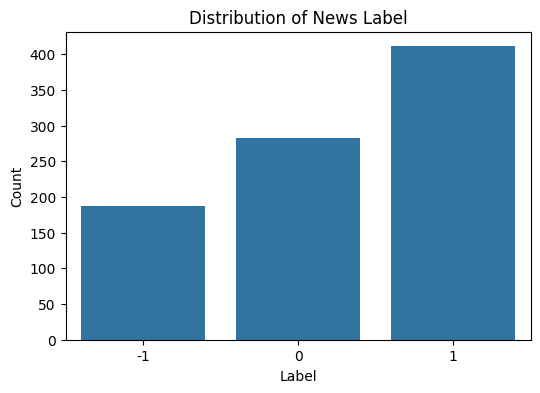

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=news, x='Rev1_label')
plt.title('Distribution of News Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


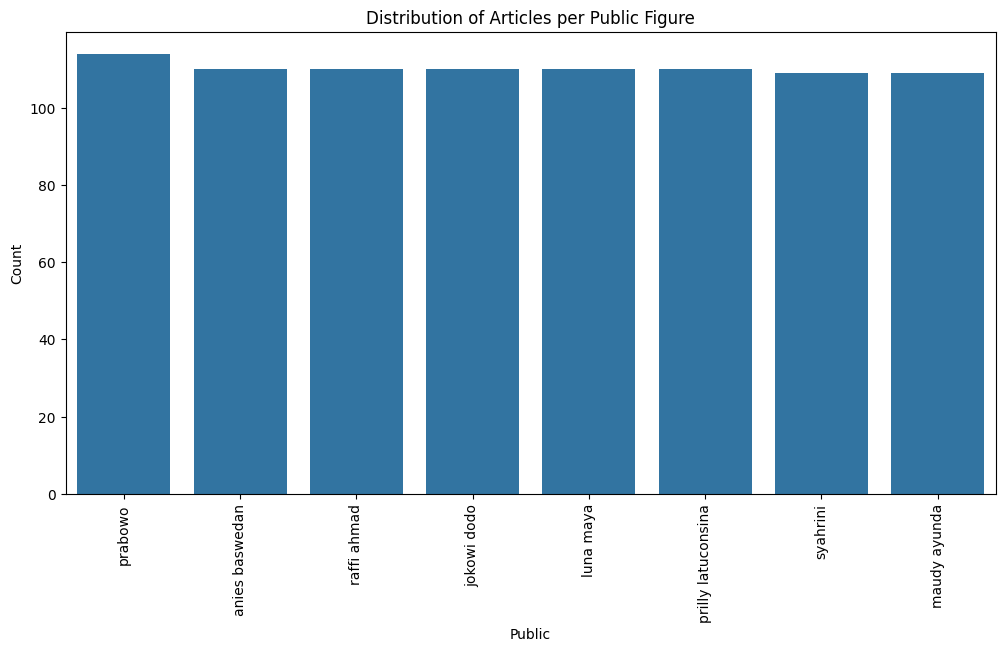

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=news, x='tokoh', order=news['tokoh'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Articles per Public Figure')
plt.xlabel('Public')
plt.ylabel('Count')
plt.show()


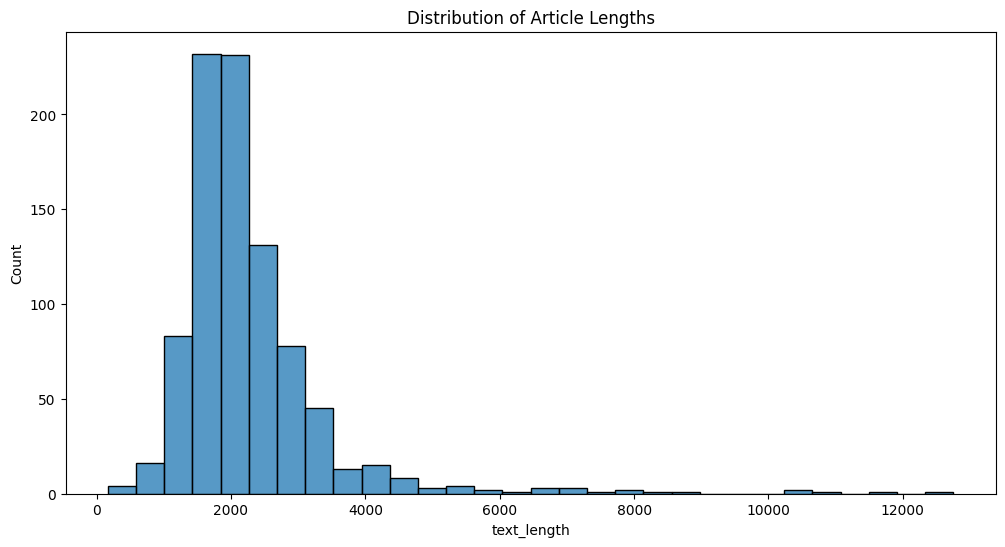

In [ ]:
news['text_length'] = news['description'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(news['text_length'], bins=30)
plt.title('Distribution of Article Lengths')
plt.show()

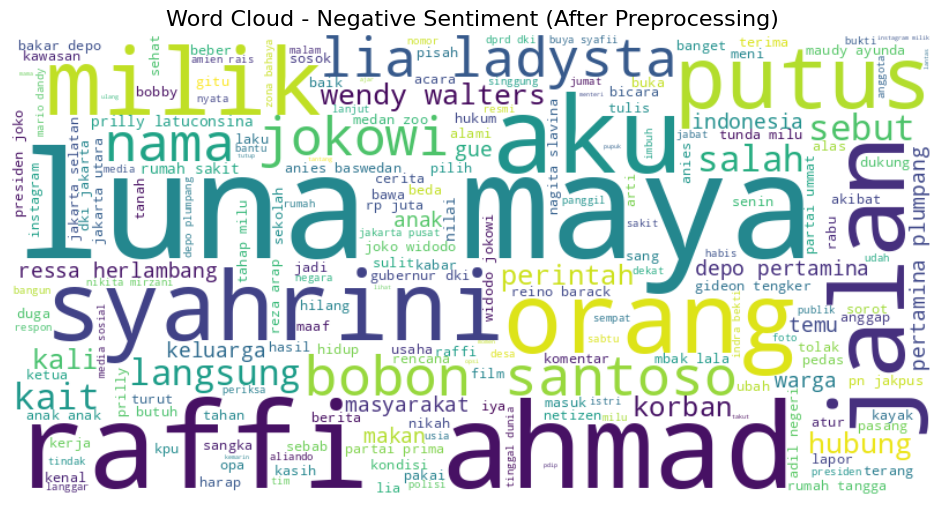

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Buat teks gabungan khusus untuk berita berlabel negatif (-1) setelah stopword removal dan stemming
negative_docs = news[news['Rev1_label'] == -1]['stemming_all_string'].dropna()

# Gabungkan semua kata dari dokumen negatif setelah stemming
negative_text_stemmed = ' '.join(negative_docs)

# Buat WordCloud
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text_stemmed)

# Tampilkan
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Sentiment (After Preprocessing)', fontsize=16)
plt.axis('off')
plt.show()

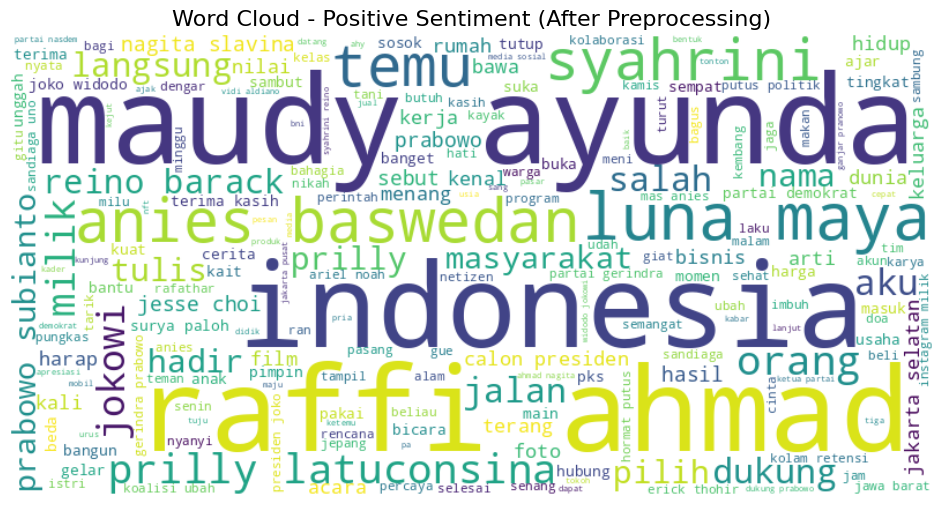

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Buat teks gabungan khusus untuk berita berlabel positif (1) setelah stopword removal dan stemming
positive_docs = news[news['Rev1_label'] == 1]['stemming_all_string'].dropna()

# Gabungkan semua kata dari dokumen positif setelah stemming
positive_text_stemmed = ' '.join(positive_docs)

# Buat WordCloud
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text_stemmed)

# Tampilkan
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Sentiment (After Preprocessing)', fontsize=16)
plt.axis('off')
plt.show()


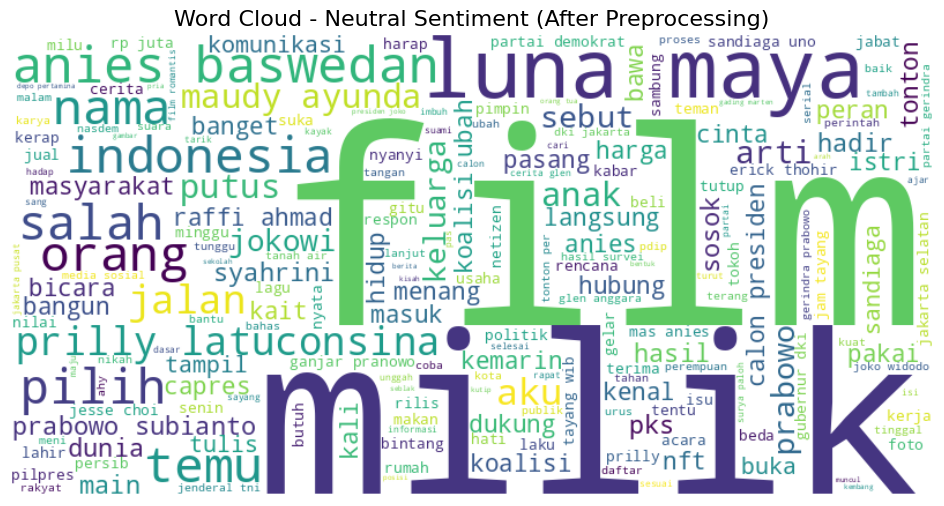

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Buat teks gabungan khusus untuk berita berlabel netral (0) setelah stopword removal dan stemming
neutral_docs = news[news['Rev1_label'] == 0]['stemming_all_string'].dropna()

# Gabungkan semua kata dari dokumen netral setelah stemming
neutral_text_stemmed = ' '.join(neutral_docs)

# Buat WordCloud
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_text_stemmed)

# Tampilkan
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Word Cloud - Neutral Sentiment (After Preprocessing)', fontsize=16)
plt.axis('off')
plt.show()


In [ ]:
news['combined_description'] = news['stemming_all_string']

count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(news['combined_description'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(count_data)

for index, topic in enumerate(lda.components_):
    print(f'Topic {index}:')
    print([count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 0:
['erick', 'warga', 'dki', 'jakarta', 'bakar', 'pertamina', 'plumpang', 'depo', 'jokowi', 'film']
Topic 1:
['anak', 'aku', 'rumah', 'orang', 'latuconsina', 'ahmad', 'raffi', 'prilly', 'maya', 'luna']
Topic 2:
['nft', 'milik', 'raffi', 'nikah', 'orang', 'choi', 'jesse', 'indonesia', 'ayunda', 'maudy']
Topic 3:
['istri', 'orang', 'milik', 'lia', 'nama', 'indonesia', 'barack', 'film', 'reino', 'syahrini']
Topic 4:
['capres', 'dukung', 'ketua', 'koalisi', 'presiden', 'baswedan', 'pks', 'partai', 'prabowo', 'anies']


In [ ]:
# Step 7: Save Cleaned Data
news.to_csv('Rev1_output_labelling.csv', index=False)

In [ ]:
# Final Insights
print("EDA completed successfully!")

EDA completed successfully!
